In [3]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline 
import sys

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [13]:
def plot(samples, D_loss, G_loss, epoch, total):

    fig = plt.figure(figsize=(10, 5))        

    gs = gridspec.GridSpec(4, 8)
    gs.update(wspace=0.05, hspace=0.05)
    
    # Plot losses
    ax = plt.subplot(gs[:, 4:])
    ax.plot(D_loss, label="discriminator's loss", color='b')
    ax.plot(G_loss, label="generator's loss", color='r')
    ax.set_xlim([0, total])
    ax.yaxis.tick_right()
    ax.legend()

    # Generate images
    for i, sample in enumerate(samples):

        if i > 4* 4 - 1:
            break
        ax = plt.subplot(gs[i % 4, int(i / 4)])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    plt.savefig('./output/' + str(epoch + 1) + '.png')
    plt.close()

In [14]:
def Conv2d(input, output_dim=64, kernel=(5, 5), strides=(2, 2), stddev=0.2, name='conv_2d'):

    with tf.variable_scope(name):
        W = tf.get_variable('Conv2dW', [kernel[0], kernel[1], input.get_shape()[-1], output_dim],
                             initializer=tf.truncated_normal_initializer(stddev=stddev))
        b = tf.get_variable('Conv2db', [output_dim], initializer=tf.zeros_initializer())
        
        return tf.nn.conv2d(input, W, strides=[1, strides[0], strides[1], 1], padding='SAME') + b

def Deconv2d(input, output_dim, batch_size, kernel=(5, 5), strides=(2, 2), stddev=0.2, name='deconv_2d'):
    
    with tf.variable_scope(name):
        W = tf.get_variable('Deconv2dW', [kernel[0], kernel[1], output_dim, input.get_shape()[-1]],
                             initializer=tf.truncated_normal_initializer(stddev=stddev))
        b = tf.get_variable('Deconv2db', [output_dim], initializer=tf.zeros_initializer())

        input_shape = input.get_shape().as_list()
        output_shape = [batch_size,
                        int(input_shape[1] * strides[0]),
                        int(input_shape[2] * strides[1]),
                        output_dim]

        deconv = tf.nn.conv2d_transpose(input, W, output_shape=output_shape,
                                        strides=[1, strides[0], strides[1], 1])
    
        return deconv + b

def Dense(input, output_dim, stddev=0.02, name='dense'):
    
    with tf.variable_scope(name):
        
        shape = input.get_shape()
        W = tf.get_variable('DenseW', [shape[1], output_dim], tf.float32,
                            tf.random_normal_initializer(stddev=stddev))
        b = tf.get_variable('Denseb', [output_dim],
                            initializer=tf.zeros_initializer())
        
        return tf.matmul(input, W) + b

def BatchNormalization(input, name='bn'):
    
    with tf.variable_scope(name):
    
        output_dim = input.get_shape()[-1]
        beta = tf.get_variable('BnBeta', [output_dim],
                            initializer=tf.zeros_initializer())
        gamma = tf.get_variable('BnGamma', [output_dim],
                            initializer=tf.ones_initializer())
    
        if len(input.get_shape()) == 2:
            mean, var = tf.nn.moments(input, [0])
        else:
            mean, var = tf.nn.moments(input, [0, 1, 2])
        return tf.nn.batch_normalization(input, mean, var, beta, gamma, 1e-5)
    
def LeakyReLU(input, leak=0.2, name='lrelu'):
    
    return tf.maximum(input, leak*input)

In [16]:
BATCH_SIZE = 64
EPOCHS = 40

def Discriminator(X, reuse=False, name='d'):

    with tf.variable_scope(name, reuse=reuse):

        if len(X.get_shape()) > 2:
            # X: -1, 28, 28, 1
            D_conv1 = Conv2d(X, output_dim=64, name='D_conv1')
        else:
            D_reshaped = tf.reshape(X, [-1, 28, 28, 1])
            D_conv1 = Conv2d(D_reshaped, output_dim=64, name='D_conv1')
        D_h1 = LeakyReLU(D_conv1) # [-1, 28, 28, 64]
        D_conv2 = Conv2d(D_h1, output_dim=128, name='D_conv2')
        D_h2 = LeakyReLU(D_conv2) # [-1, 28, 28, 128]
        D_r2 = tf.reshape(D_h2, [-1, 256])
        D_h3 = LeakyReLU(D_r2) # [-1, 256]
        D_h4 = tf.nn.dropout(D_h3, 0.5)
        D_h5 = Dense(D_h4, output_dim=1, name='D_h5') # [-1, 1]
        return tf.nn.sigmoid(D_h5)

def Generator(z, name='g'):

    with tf.variable_scope(name):

        G_1 = Dense(z, output_dim=1024, name='G_1') # [-1, 1024]
        G_bn1 = BatchNormalization(G_1, name='G_bn1')
        G_h1 = tf.nn.relu(G_bn1)
        G_2 = Dense(G_h1, output_dim=7*7*128, name='G_2') # [-1, 7*7*128]
        G_bn2 = BatchNormalization(G_2, name='G_bn2')        
        G_h2 = tf.nn.relu(G_bn2)
        G_r2 = tf.reshape(G_h2, [-1, 7, 7, 128])
        G_conv3 = Deconv2d(G_r2, output_dim=64, batch_size=BATCH_SIZE, name='G_conv3')
        G_bn3 = BatchNormalization(G_conv3, name='G_bn3')        
        G_h3 = tf.nn.relu(G_bn3)
        G_conv4 = Deconv2d(G_h3, output_dim=1, batch_size=BATCH_SIZE, name='G_conv4')
        G_r4 = tf.reshape(G_conv4, [-1, 784])
        return tf.nn.sigmoid(G_r4)

X = tf.placeholder(tf.float32, shape=[None, 784])
z = tf.placeholder(tf.float32, shape=[None, 100])

G = Generator(z, 'G')
D_real = Discriminator(X, False, 'D')
D_fake = Discriminator(G, True, 'D')

D_loss = -tf.reduce_mean(tf.log(D_real) - tf.log(D_fake)) # Train to judge if the data is real correctly
G_loss = -tf.reduce_mean(tf.log(D_fake)) # Train to pass the discriminator as real data

vars = tf.trainable_variables()
d_params = [v for v in vars if v.name.startswith('D/')]
g_params = [v for v in vars if v.name.startswith('G/')]

D_solver = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0.1).minimize(D_loss, var_list=d_params)
G_solver = tf.train.AdamOptimizer(learning_rate=2e-4, beta1=0.3).minimize(G_loss, var_list=g_params)BATCH_SIZE = 64
EPOCHS = 40

def Discriminator(X, reuse=False, name='d'):

    with tf.variable_scope(name, reuse=reuse):

        if len(X.get_shape()) > 2:
            # X: -1, 28, 28, 1
            D_conv1 = Conv2d(X, output_dim=64, name='D_conv1')
        else:
            D_reshaped = tf.reshape(X, [-1, 28, 28, 1])
            D_conv1 = Conv2d(D_reshaped, output_dim=64, name='D_conv1')
        D_h1 = LeakyReLU(D_conv1) # [-1, 28, 28, 64]
        D_conv2 = Conv2d(D_h1, output_dim=128, name='D_conv2')
        D_h2 = LeakyReLU(D_conv2) # [-1, 28, 28, 128]
        D_r2 = tf.reshape(D_h2, [-1, 256])
        D_h3 = LeakyReLU(D_r2) # [-1, 256]
        D_h4 = tf.nn.dropout(D_h3, 0.5)
        D_h5 = Dense(D_h4, output_dim=1, name='D_h5') # [-1, 1]
        return tf.nn.sigmoid(D_h5)

def Generator(z, name='g'):

    with tf.variable_scope(name):

        G_1 = Dense(z, output_dim=1024, name='G_1') # [-1, 1024]
        G_bn1 = BatchNormalization(G_1, name='G_bn1')
        G_h1 = tf.nn.relu(G_bn1)
        G_2 = Dense(G_h1, output_dim=7*7*128, name='G_2') # [-1, 7*7*128]
        G_bn2 = BatchNormalization(G_2, name='G_bn2')        
        G_h2 = tf.nn.relu(G_bn2)
        G_r2 = tf.reshape(G_h2, [-1, 7, 7, 128])
        G_conv3 = Deconv2d(G_r2, output_dim=64, batch_size=BATCH_SIZE, name='G_conv3')
        G_bn3 = BatchNormalization(G_conv3, name='G_bn3')        
        G_h3 = tf.nn.relu(G_bn3)
        G_conv4 = Deconv2d(G_h3, output_dim=1, batch_size=BATCH_SIZE, name='G_conv4')
        G_r4 = tf.reshape(G_conv4, [-1, 784])
        return tf.nn.sigmoid(G_r4)

X = tf.placeholder(tf.float32, shape=[None, 784])
z = tf.placeholder(tf.float32, shape=[None, 100])

G = Generator(z, 'G')
D_real = Discriminator(X, False, 'D')
D_fake = Discriminator(G, True, 'D')

D_loss = -tf.reduce_mean(tf.log(D_real) - tf.log(D_fake)) # Train to judge if the data is real correctly
G_loss = -tf.reduce_mean(tf.log(D_fake)) # Train to pass the discriminator as real data

vars = tf.trainable_variables()
d_params = [v for v in vars if v.name.startswith('D/')]
g_params = [v for v in vars if v.name.startswith('G/')]

D_solver = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0.1).minimize(D_loss, var_list=d_params)
G_solver = tf.train.AdamOptimizer(learning_rate=2e-4, beta1=0.3).minimize(G_loss, var_list=g_params)

SyntaxError: invalid syntax (<ipython-input-16-b6ff84be858a>, line 56)

0 / 859: -0.081988, 0.865336

1 / 859: -0.070667, 0.867702

2 / 859: -0.076795, 0.886248

3 / 859: -0.094220, 0.892940

4 / 859: -0.092541, 0.910386

5 / 859: -0.082885, 0.925700

6 / 859: -0.089548, 0.950908

7 / 859: -0.124725, 0.953533

8 / 859: -0.144625, 0.979270

9 / 859: -0.123253, 0.986672

10 / 859: -0.150894, 1.049989

11 / 859: -0.148968, 1.036413

12 / 859: -0.167769, 1.078315

13 / 859: -0.189667, 1.089068

14 / 859: -0.195110, 1.131213

15 / 859: -0.230916, 1.148267

16 / 859: -0.243503, 1.190677

17 / 859: -0.244244, 1.215222

18 / 859: -0.281195, 1.268993

19 / 859: -0.316255, 1.294429

20 / 859: -0.342932, 1.317663

21 / 859: -0.389082, 1.354345

22 / 859: -0.348210, 1.379626

23 / 859: -0.420816, 1.413678

24 / 859: -0.414547, 1.440246

25 / 859: -0.454616, 1.468666

26 / 859: -0.418227, 1.458959

27 / 859: -0.427530, 1.482353

28 / 859: -0.437176, 1.485690

29 / 859: -0.450577, 1.501837

30 / 859: -0.446939, 1.516208

31 / 859: -0.395698, 1.495946

32 / 859: -0.447103, 1.506497

33 / 859: -0.440589, 1.515871

34 / 859: -0.434341, 1.528593

35 / 859: -0.438749, 1.523907

36 / 859: -0.389539, 1.522504

37 / 859: -0.400662, 1.499982

38 / 859: -0.346890, 1.483305

39 / 859: -0.308769, 1.480680

40 / 859: -0.317988, 1.455929

41 / 859: -0.270341, 1.400582

42 / 859: -0.269610, 1.371345

43 / 859: -0.217786, 1.342447

44 / 859: -0.152792, 1.305686

45 / 859: -0.154955, 1.266112

46 / 859: -0.121363, 1.247212

47 / 859: -0.067822, 1.227459

48 / 859: -0.032796, 1.194397

49 / 859: -0.050780, 1.166125

50 / 859: -0.005491, 1.144042

51 / 859: 0.001449, 1.121673

52 / 859: 0.022104, 1.107682

53 / 859: 0.030748, 1.087587

54 / 859: 0.053473, 1.077010

55 / 859: 0.050400, 1.048911

56 / 859: 0.049130, 1.034216

57 / 859: 0.041150, 1.029238

58 / 859: 0.068744, 1.019874

59 / 859: 0.052133, 1.002527

60 / 859: 0.085894, 0.989218

61 / 859: 0.044314, 0.983107

62 / 859: 0.096797, 0.977513

63 / 859: 0.102565, 0.961058

64 / 859: 0.112450, 0.961610

65 / 859: 0.102081, 0.948616

66 / 859: 0.079304, 0.936498

67 / 859: 0.054434, 0.940076

68 / 859: 0.067196, 0.926077

69 / 859: 0.084098, 0.920050

70 / 859: 0.075567, 0.913706

71 / 859: 0.063739, 0.917186

72 / 859: 0.081333, 0.904369

73 / 859: 0.045327, 0.901676

74 / 859: 0.070767, 0.892424

75 / 859: 0.066878, 0.888717

76 / 859: 0.059719, 0.875673

77 / 859: 0.030748, 0.875987

78 / 859: 0.045920, 0.863660

79 / 859: 0.064645, 0.857666

80 / 859: 0.050129, 0.846989

81 / 859: 0.037559, 0.842160

82 / 859: 0.074178, 0.827364

83 / 859: 0.053965, 0.820942

84 / 859: 0.048197, 0.805120

85 / 859: 0.035232, 0.804713

86 / 859: 0.060422, 0.793104

87 / 859: 0.034908, 0.786599

88 / 859: 0.034785, 0.776538

89 / 859: 0.029013, 0.769331

90 / 859: 0.035866, 0.768317

91 / 859: 0.044692, 0.759197

92 / 859: 0.013226, 0.750682

93 / 859: 0.027718, 0.739183

94 / 859: 0.005168, 0.739079

95 / 859: 0.040230, 0.730194

96 / 859: 0.016707, 0.727146

97 / 859: 0.009055, 0.719304

98 / 859: 0.030976, 0.713544

99 / 859: 0.006722, 0.704179

100 / 859: 0.012994, 0.706581

101 / 859: 0.001513, 0.697441

102 / 859: 0.020624, 0.700676

103 / 859: 0.022069, 0.687488

104 / 859: -0.000231, 0.681990

105 / 859: -0.004582, 0.686247

106 / 859: 0.001744, 0.682146

107 / 859: -0.016188, 0.689385

108 / 859: -0.013039, 0.688031

109 / 859: -0.028226, 0.689569

110 / 859: -0.029995, 0.691205

111 / 859: -0.036837, 0.694119

112 / 859: -0.049798, 0.699582

113 / 859: -0.048609, 0.705788

114 / 859: -0.055118, 0.709949

115 / 859: -0.067971, 0.714374

116 / 859: -0.070282, 0.720447

117 / 859: -0.084136, 0.725629

118 / 859: -0.096355, 0.732386

119 / 859: -0.096646, 0.732745

120 / 859: -0.113033, 0.735554

121 / 859: -0.108193, 0.734759

122 / 859: -0.114484, 0.737696

123 / 859: -0.104545, 0.734766

124 / 859: -0.123590, 0.733299

125 / 859: -0.125325, 0.727756

126 / 859: -0.128643, 0.728610

127 / 859: -0.124730, 0.725395

128 / 859: -0.127259, 0.724882

129 / 859: -0.131037, 0.720856

130 / 859: -0.126242, 0.722258

131 / 859: -0.134606, 0.719084

132 / 859: -0.130263, 0.715156

133 / 859: -0.133908, 0.719891

134 / 859: -0.133022, 0.711274

135 / 859: -0.129649, 0.710106

136 / 859: -0.130433, 0.711213

137 / 859: -0.136958, 0.709749

138 / 859: -0.141564, 0.708171

139 / 859: -0.130401, 0.702353

140 / 859: -0.138938, 0.702399

141 / 859: -0.143510, 0.693963

142 / 859: -0.130641, 0.692337

143 / 859: -0.136096, 0.695831

144 / 859: -0.131740, 0.687546

145 / 859: -0.130265, 0.679714

146 / 859: -0.118126, 0.676938

147 / 859: -0.134634, 0.674004

148 / 859: -0.108962, 0.670396

149 / 859: -0.117222, 0.665194

150 / 859: -0.104590, 0.666304

151 / 859: -0.108681, 0.658233

152 / 859: -0.114477, 0.656998

153 / 859: -0.096848, 0.656577

154 / 859: -0.112321, 0.666219

155 / 859: -0.139893, 0.668206

156 / 859: -0.129676, 0.683821

157 / 859: -0.137030, 0.706687

158 / 859: -0.159328, 0.720399

159 / 859: -0.171995, 0.734000

160 / 859: -0.179437, 0.742313

161 / 859: -0.201615, 0.757590

162 / 859: -0.207531, 0.767188

163 / 859: -0.205865, 0.768707

164 / 859: -0.212823, 0.777646

165 / 859: -0.219906, 0.778543

166 / 859: -0.215584, 0.762747

167 / 859: -0.201152, 0.763578

168 / 859: -0.206179, 0.755896

169 / 859: -0.200258, 0.749144

170 / 859: -0.197467, 0.744631

171 / 859: -0.192975, 0.745449

172 / 859: -0.193363, 0.743829

173 / 859: -0.201514, 0.729302

174 / 859: -0.186408, 0.729895

175 / 859: -0.180090, 0.715050

176 / 859: -0.168160, 0.706345

177 / 859: -0.173883, 0.706605

178 / 859: -0.170497, 0.695922

179 / 859: -0.167258, 0.686612

180 / 859: -0.150542, 0.677535

181 / 859: -0.155457, 0.668145

182 / 859: -0.145844, 0.669232

183 / 859: -0.138067, 0.667642

184 / 859: -0.136410, 0.660180

185 / 859: -0.137598, 0.665762

186 / 859: -0.144011, 0.661524

187 / 859: -0.152108, 0.669881

188 / 859: -0.152323, 0.677486

189 / 859: -0.171292, 0.684461

190 / 859: -0.184457, 0.698942

191 / 859: -0.191514, 0.713532

192 / 859: -0.199014, 0.726814

193 / 859: -0.201733, 0.723960

194 / 859: -0.217589, 0.737247

195 / 859: -0.217497, 0.748496

196 / 859: -0.231411, 0.744828

197 / 859: -0.229203, 0.747066

198 / 859: -0.236417, 0.745692

199 / 859: -0.223536, 0.740939

200 / 859: -0.226464, 0.731952

201 / 859: -0.236468, 0.731622

202 / 859: -0.218036, 0.729882

203 / 859: -0.219219, 0.722032

204 / 859: -0.209640, 0.710909

205 / 859: -0.198830, 0.704416

206 / 859: -0.212179, 0.701764

207 / 859: -0.206924, 0.695038

208 / 859: -0.207119, 0.695462

209 / 859: -0.198354, 0.693374

210 / 859: -0.199888, 0.688837

211 / 859: -0.205098, 0.692811

212 / 859: -0.200587, 0.694918

213 / 859: -0.223195, 0.690889

214 / 859: -0.217559, 0.686605

215 / 859: -0.210718, 0.689695

216 / 859: -0.212095, 0.680282

217 / 859: -0.210470, 0.677881

218 / 859: -0.206709, 0.669815

219 / 859: -0.204589, 0.663859

220 / 859: -0.197981, 0.657470

221 / 859: -0.183196, 0.641270

222 / 859: -0.168222, 0.631392

223 / 859: -0.173362, 0.627075

224 / 859: -0.164882, 0.637262

225 / 859: -0.159831, 0.641858

226 / 859: -0.169151, 0.653962

227 / 859: -0.184679, 0.668099

228 / 859: -0.205593, 0.694700

229 / 859: -0.236445, 0.718305

230 / 859: -0.248434, 0.735630

231 / 859: -0.261126, 0.748987

232 / 859: -0.266933, 0.762185

233 / 859: -0.266713, 0.761515

234 / 859: -0.288351, 0.761161

235 / 859: -0.278472, 0.759612

236 / 859: -0.268036, 0.754200

237 / 859: -0.260223, 0.757405

238 / 859: -0.265859, 0.751846

239 / 859: -0.291667, 0.750099

240 / 859: -0.271742, 0.747860

241 / 859: -0.277268, 0.755654

242 / 859: -0.265892, 0.749257

243 / 859: -0.267371, 0.753587

244 / 859: -0.279784, 0.759521

245 / 859: -0.281731, 0.756517

246 / 859: -0.261107, 0.759002

247 / 859: -0.295783, 0.768881

248 / 859: -0.291968, 0.764022

249 / 859: -0.289117, 0.759748

250 / 859: -0.289915, 0.773314

251 / 859: -0.308521, 0.765217

252 / 859: -0.290734, 0.759643

253 / 859: -0.288305, 0.762935

254 / 859: -0.287556, 0.756171

255 / 859: -0.276056, 0.758696

256 / 859: -0.295738, 0.756931

257 / 859: -0.258150, 0.754193

258 / 859: -0.295325, 0.751448

259 / 859: -0.280629, 0.747177

260 / 859: -0.271915, 0.745341

261 / 859: -0.270405, 0.748822

262 / 859: -0.282224, 0.737820

263 / 859: -0.279211, 0.744208

264 / 859: -0.276167, 0.748536

265 / 859: -0.269418, 0.750701

266 / 859: -0.281948, 0.749478

267 / 859: -0.287921, 0.744027

268 / 859: -0.295429, 0.748443

269 / 859: -0.278604, 0.761138

270 / 859: -0.289272, 0.758647

271 / 859: -0.286680, 0.755911

272 / 859: -0.291760, 0.756502

273 / 859: -0.277313, 0.757194

274 / 859: -0.289187, 0.754773

275 / 859: -0.291243, 0.763904

276 / 859: -0.300982, 0.766524

277 / 859: -0.300590, 0.759177

278 / 859: -0.283080, 0.755045

279 / 859: -0.290505, 0.760658

280 / 859: -0.294324, 0.767695

281 / 859: -0.296687, 0.764959

282 / 859: -0.300891, 0.764341

283 / 859: -0.298760, 0.763098

284 / 859: -0.285728, 0.765046

285 / 859: -0.292157, 0.764903

286 / 859: -0.292255, 0.764912

287 / 859: -0.292890, 0.761238

288 / 859: -0.301805, 0.761342

289 / 859: -0.294602, 0.761531

290 / 859: -0.296148, 0.762770

291 / 859: -0.299240, 0.765746

292 / 859: -0.286265, 0.760677

293 / 859: -0.281247, 0.762541

294 / 859: -0.290190, 0.753443

295 / 859: -0.283498, 0.757810

296 / 859: -0.294226, 0.760533

297 / 859: -0.308186, 0.751227

298 / 859: -0.276370, 0.743738

299 / 859: -0.272982, 0.734874

300 / 859: -0.276587, 0.754535

301 / 859: -0.280905, 0.750364

302 / 859: -0.265312, 0.746069

303 / 859: -0.258511, 0.740338

304 / 859: -0.269382, 0.736842

305 / 859: -0.281999, 0.743464

306 / 859: -0.280813, 0.744885

307 / 859: -0.261008, 0.728466

308 / 859: -0.286970, 0.728439

309 / 859: -0.266605, 0.729177

310 / 859: -0.255934, 0.731219

311 / 859: -0.256123, 0.726690

312 / 859: -0.259458, 0.729288

313 / 859: -0.271279, 0.731914

314 / 859: -0.262403, 0.726615

315 / 859: -0.276087, 0.732132

316 / 859: -0.237370, 0.714243

317 / 859: -0.260566, 0.712907

318 / 859: -0.259313, 0.726421

319 / 859: -0.234877, 0.713758

320 / 859: -0.246860, 0.714487

321 / 859: -0.254380, 0.722436

322 / 859: -0.254431, 0.727754

323 / 859: -0.245279, 0.724340

324 / 859: -0.227499, 0.723245

325 / 859: -0.196999, 0.729927

326 / 859: -0.229817, 0.711829

327 / 859: -0.228664, 0.715600

328 / 859: -0.196333, 0.706668

329 / 859: -0.207460, 0.710408

330 / 859: -0.221292, 0.716552

331 / 859: -0.233683, 0.716443

332 / 859: -0.214770, 0.726559

333 / 859: -0.189594, 0.711100

334 / 859: -0.165548, 0.728765

335 / 859: -0.187604, 0.707529

336 / 859: -0.200639, 0.693848

337 / 859: -0.182082, 0.697861

338 / 859: -0.182309, 0.722751

339 / 859: -0.201088, 0.712080

340 / 859: -0.164171, 0.704105

341 / 859: -0.170383, 0.707209

342 / 859: -0.199788, 0.709126

343 / 859: -0.177789, 0.729316

344 / 859: -0.165553, 0.719875

345 / 859: -0.145219, 0.719525

346 / 859: -0.174261, 0.721202

347 / 859: -0.150414, 0.719522

348 / 859: -0.150491, 0.739119

349 / 859: -0.123493, 0.729350

350 / 859: -0.115642, 0.731289

351 / 859: -0.141287, 0.735087

352 / 859: -0.164378, 0.739090

353 / 859: -0.151377, 0.746054

354 / 859: -0.138868, 0.721988

355 / 859: -0.151245, 0.755092

356 / 859: -0.128722, 0.748400

357 / 859: -0.160159, 0.765630

358 / 859: -0.122770, 0.742896

359 / 859: -0.107833, 0.762299

360 / 859: -0.113532, 0.750326

361 / 859: -0.134239, 0.765639

362 / 859: -0.116393, 0.761062

363 / 859: -0.097107, 0.768919

364 / 859: -0.140376, 0.779319

365 / 859: -0.136866, 0.780982

366 / 859: -0.110925, 0.787090

367 / 859: -0.091392, 0.781757

368 / 859: -0.119657, 0.783703

369 / 859: -0.138468, 0.790561

370 / 859: -0.106421, 0.776038

371 / 859: -0.098914, 0.783762

372 / 859: -0.138004, 0.794165

373 / 859: -0.102072, 0.774955

374 / 859: -0.122346, 0.800901

375 / 859: -0.114283, 0.804813

376 / 859: -0.082816, 0.791300

377 / 859: -0.114226, 0.765734

378 / 859: -0.119766, 0.764299

379 / 859: -0.101800, 0.751801

380 / 859: -0.115183, 0.751494

381 / 859: -0.091845, 0.739435

382 / 859: -0.101337, 0.743423

383 / 859: -0.112278, 0.743484

384 / 859: -0.151887, 0.736236

385 / 859: -0.093933, 0.732544

386 / 859: -0.122495, 0.733959

387 / 859: -0.104320, 0.728368

388 / 859: -0.111699, 0.738703

389 / 859: -0.092476, 0.710232

390 / 859: -0.094953, 0.707931

391 / 859: -0.115734, 0.705631

392 / 859: -0.107522, 0.713371

393 / 859: -0.101955, 0.714076

394 / 859: -0.117850, 0.692300

395 / 859: -0.098175, 0.678551

396 / 859: -0.099334, 0.670542

397 / 859: -0.091645, 0.688767

398 / 859: -0.093364, 0.675374

399 / 859: -0.101654, 0.662908

400 / 859: -0.086255, 0.666727

401 / 859: -0.109902, 0.650830

402 / 859: -0.102530, 0.656362

403 / 859: -0.122811, 0.663650

404 / 859: -0.108832, 0.651036

405 / 859: -0.089821, 0.639998

406 / 859: -0.092531, 0.633639

407 / 859: -0.114264, 0.634982

408 / 859: -0.116569, 0.643166

409 / 859: -0.095363, 0.646655

410 / 859: -0.114623, 0.646676

411 / 859: -0.093856, 0.641131

412 / 859: -0.082821, 0.643219

413 / 859: -0.107483, 0.628323

414 / 859: -0.109581, 0.636179

415 / 859: -0.086544, 0.614254

416 / 859: -0.119337, 0.613263

417 / 859: -0.071003, 0.611167

418 / 859: -0.118471, 0.630421

419 / 859: -0.088503, 0.624658

420 / 859: -0.106692, 0.626996

421 / 859: -0.110329, 0.614287

422 / 859: -0.126704, 0.613500

423 / 859: -0.090276, 0.624070

424 / 859: -0.107700, 0.605046

425 / 859: -0.105621, 0.625976

426 / 859: -0.095184, 0.618982

427 / 859: -0.083035, 0.616793

428 / 859: -0.105086, 0.620184

429 / 859: -0.095405, 0.615600

430 / 859: -0.109780, 0.629008

431 / 859: -0.096613, 0.625232

432 / 859: -0.098287, 0.607657

433 / 859: -0.111448, 0.617089

434 / 859: -0.096754, 0.616302

435 / 859: -0.113402, 0.621741

436 / 859: -0.109096, 0.621707

437 / 859: -0.103497, 0.611613

438 / 859: -0.100618, 0.611217

439 / 859: -0.079452, 0.635989

440 / 859: -0.108536, 0.616258

441 / 859: -0.109873, 0.621201

442 / 859: -0.093243, 0.645077

443 / 859: -0.105564, 0.635272

444 / 859: -0.110807, 0.623916

445 / 859: -0.104699, 0.618227

446 / 859: -0.094997, 0.608631

447 / 859: -0.092269, 0.625316

448 / 859: -0.111715, 0.620014

449 / 859: -0.102627, 0.622441

450 / 859: -0.124556, 0.622300

451 / 859: -0.082653, 0.614209

452 / 859: -0.099558, 0.615997

453 / 859: -0.109961, 0.616104

454 / 859: -0.105216, 0.604574

455 / 859: -0.086794, 0.608472

456 / 859: -0.101075, 0.625093

457 / 859: -0.092120, 0.623836

458 / 859: -0.113406, 0.624998

459 / 859: -0.090983, 0.606655

460 / 859: -0.123928, 0.604741

461 / 859: -0.079960, 0.621539

462 / 859: -0.092355, 0.611117

463 / 859: -0.106944, 0.637250

464 / 859: -0.093355, 0.612450

465 / 859: -0.094927, 0.616419

466 / 859: -0.081945, 0.614670

467 / 859: -0.101266, 0.610111

468 / 859: -0.101686, 0.625975

469 / 859: -0.106968, 0.617427

470 / 859: -0.096850, 0.610026

471 / 859: -0.116035, 0.613001

472 / 859: -0.104022, 0.612590

473 / 859: -0.118562, 0.616390

474 / 859: -0.110275, 0.608009

475 / 859: -0.084481, 0.622286

476 / 859: -0.099976, 0.625826

477 / 859: -0.106561, 0.620438

478 / 859: -0.095016, 0.622144

479 / 859: -0.116088, 0.607394

480 / 859: -0.104200, 0.618587

481 / 859: -0.108161, 0.615517

482 / 859: -0.094356, 0.625479

483 / 859: -0.096281, 0.623808

484 / 859: -0.098080, 0.627623

485 / 859: -0.103174, 0.614468

486 / 859: -0.095960, 0.617352

487 / 859: -0.096816, 0.622856

488 / 859: -0.120584, 0.619071

489 / 859: -0.105802, 0.622205

490 / 859: -0.107306, 0.608886

491 / 859: -0.121689, 0.607892

492 / 859: -0.100629, 0.619228

493 / 859: -0.100229, 0.614158

494 / 859: -0.082454, 0.613984

495 / 859: -0.099852, 0.611487

496 / 859: -0.122547, 0.617544

497 / 859: -0.108211, 0.630232

498 / 859: -0.087520, 0.620834

499 / 859: -0.098539, 0.621073

500 / 859: -0.110922, 0.601154

501 / 859: -0.094435, 0.604108

502 / 859: -0.096140, 0.616502

503 / 859: -0.098962, 0.624780

504 / 859: -0.103348, 0.624408

505 / 859: -0.088418, 0.626194

506 / 859: -0.093811, 0.629752

507 / 859: -0.111943, 0.622075

508 / 859: -0.100866, 0.637152

509 / 859: -0.106575, 0.632374

510 / 859: -0.089532, 0.630647

511 / 859: -0.104094, 0.631202

512 / 859: -0.096876, 0.645287

513 / 859: -0.107057, 0.646783

514 / 859: -0.078037, 0.627458

515 / 859: -0.082340, 0.648474

516 / 859: -0.117693, 0.628625

517 / 859: -0.096190, 0.629203

518 / 859: -0.103774, 0.640857

519 / 859: -0.110263, 0.645661

520 / 859: -0.102160, 0.633826

521 / 859: -0.107719, 0.639748

522 / 859: -0.111006, 0.640360

523 / 859: -0.099099, 0.658456

524 / 859: -0.094621, 0.628955

525 / 859: -0.103864, 0.639059

526 / 859: -0.099525, 0.637146

527 / 859: -0.115515, 0.627220

528 / 859: -0.091134, 0.640694

529 / 859: -0.091519, 0.641729

530 / 859: -0.083395, 0.650572

531 / 859: -0.086520, 0.630783

532 / 859: -0.088367, 0.638400

533 / 859: -0.098014, 0.638301

534 / 859: -0.093203, 0.649521

535 / 859: -0.110490, 0.639129

536 / 859: -0.116516, 0.647558

537 / 859: -0.123671, 0.657179

538 / 859: -0.120542, 0.655199

539 / 859: -0.090895, 0.627148

540 / 859: -0.121625, 0.660625

541 / 859: -0.104441, 0.653175

542 / 859: -0.099762, 0.658234

543 / 859: -0.118747, 0.646809

544 / 859: -0.092518, 0.664378

545 / 859: -0.112622, 0.664706

546 / 859: -0.119851, 0.654530

547 / 859: -0.116316, 0.654214

548 / 859: -0.113890, 0.675120

549 / 859: -0.106553, 0.664047

550 / 859: -0.105959, 0.654330

551 / 859: -0.111306, 0.674470

552 / 859: -0.129677, 0.662163

553 / 859: -0.103757, 0.669102

554 / 859: -0.120407, 0.678071

555 / 859: -0.097362, 0.671673

556 / 859: -0.101226, 0.670422

557 / 859: -0.100821, 0.690820

558 / 859: -0.116646, 0.684282

559 / 859: -0.127436, 0.689799

560 / 859: -0.096940, 0.689056

561 / 859: -0.112265, 0.689188

562 / 859: -0.126975, 0.689905

563 / 859: -0.118104, 0.678030

564 / 859: -0.101915, 0.688139

565 / 859: -0.097936, 0.691948

566 / 859: -0.109003, 0.706059

567 / 859: -0.114731, 0.679185

568 / 859: -0.101389, 0.700556

569 / 859: -0.108913, 0.689610

570 / 859: -0.101988, 0.677587

571 / 859: -0.114232, 0.686499

572 / 859: -0.117231, 0.678751

573 / 859: -0.120217, 0.681897

574 / 859: -0.098444, 0.687398

575 / 859: -0.073286, 0.690219

576 / 859: -0.101191, 0.690401

577 / 859: -0.080912, 0.709205

578 / 859: -0.116484, 0.708390

579 / 859: -0.113020, 0.728091

580 / 859: -0.104248, 0.715063

581 / 859: -0.125414, 0.737233

582 / 859: -0.114006, 0.729736

583 / 859: -0.126800, 0.725061

584 / 859: -0.114317, 0.717040

585 / 859: -0.100939, 0.737934

586 / 859: -0.109914, 0.730178

587 / 859: -0.111936, 0.747787

588 / 859: -0.107248, 0.735260

589 / 859: -0.106505, 0.739265

590 / 859: -0.110934, 0.743819

591 / 859: -0.100375, 0.749508

592 / 859: -0.105881, 0.737890

593 / 859: -0.137854, 0.724387

594 / 859: -0.115656, 0.745326

595 / 859: -0.133392, 0.754899

596 / 859: -0.133189, 0.760701

597 / 859: -0.120364, 0.748983

598 / 859: -0.123321, 0.740610

599 / 859: -0.139447, 0.762503

600 / 859: -0.137676, 0.768111

601 / 859: -0.103891, 0.755152

602 / 859: -0.113061, 0.753251

603 / 859: -0.128833, 0.762608

604 / 859: -0.107389, 0.757351

605 / 859: -0.111844, 0.772901

606 / 859: -0.099046, 0.770451

607 / 859: -0.112492, 0.777465

608 / 859: -0.157875, 0.773471

609 / 859: -0.130611, 0.794676

610 / 859: -0.136544, 0.774258

611 / 859: -0.129282, 0.777964

612 / 859: -0.127533, 0.791841

613 / 859: -0.125269, 0.792015

614 / 859: -0.155144, 0.812910

615 / 859: -0.126789, 0.811227

616 / 859: -0.141426, 0.818497

617 / 859: -0.158550, 0.807714

618 / 859: -0.146052, 0.818479

619 / 859: -0.132982, 0.810266

620 / 859: -0.133858, 0.796285

621 / 859: -0.112836, 0.803485

622 / 859: -0.131274, 0.809001

623 / 859: -0.115059, 0.791108

624 / 859: -0.146849, 0.802041

625 / 859: -0.136040, 0.806289

626 / 859: -0.127121, 0.804779

627 / 859: -0.137606, 0.805141

628 / 859: -0.125601, 0.791154

629 / 859: -0.138617, 0.796718

630 / 859: -0.157392, 0.807374

631 / 859: -0.150322, 0.795989

632 / 859: -0.123946, 0.819173

633 / 859: -0.141222, 0.792121

634 / 859: -0.146111, 0.793201

635 / 859: -0.145742, 0.780817

636 / 859: -0.158509, 0.814859

637 / 859: -0.152379, 0.808275

638 / 859: -0.145655, 0.818524

639 / 859: -0.142287, 0.806040

640 / 859: -0.168820, 0.832309

641 / 859: -0.142521, 0.848749

642 / 859: -0.129051, 0.860914

643 / 859: -0.143110, 0.852941

644 / 859: -0.151721, 0.862702

645 / 859: -0.136876, 0.882785

646 / 859: -0.152089, 0.881637

647 / 859: -0.163870, 0.871642

648 / 859: -0.146076, 0.870991

649 / 859: -0.161329, 0.863188

650 / 859: -0.128266, 0.871647

651 / 859: -0.125376, 0.877634

652 / 859: -0.152160, 0.873379

653 / 859: -0.140128, 0.875708

654 / 859: -0.140606, 0.877362

655 / 859: -0.153400, 0.889516

656 / 859: -0.155129, 0.877762

657 / 859: -0.160289, 0.874142

658 / 859: -0.163237, 0.894752

659 / 859: -0.126973, 0.914233

660 / 859: -0.155279, 0.903097

661 / 859: -0.179404, 0.916281

662 / 859: -0.157160, 0.923280

663 / 859: -0.148624, 0.919817

664 / 859: -0.136829, 0.927789

665 / 859: -0.135521, 0.938916

666 / 859: -0.155335, 0.927396

667 / 859: -0.141444, 0.930775

668 / 859: -0.171470, 0.909484

669 / 859: -0.142933, 0.928181

670 / 859: -0.148417, 0.949318

671 / 859: -0.147222, 0.939343

672 / 859: -0.163800, 0.962893

673 / 859: -0.128172, 0.968884

674 / 859: -0.167146, 0.959958

675 / 859: -0.162736, 0.974432

676 / 859: -0.152329, 0.954931

677 / 859: -0.157455, 0.971179

678 / 859: -0.139327, 0.995858

679 / 859: -0.135827, 1.005868

680 / 859: -0.130315, 0.987767

681 / 859: -0.121671, 0.984877

682 / 859: -0.140084, 0.972425

683 / 859: -0.150618, 1.000480

684 / 859: -0.117440, 0.965497

685 / 859: -0.132045, 0.958548

686 / 859: -0.120302, 0.969968

687 / 859: -0.165040, 0.985194

688 / 859: -0.164295, 0.971373

689 / 859: -0.124870, 0.974354

690 / 859: -0.149422, 0.962617

691 / 859: -0.152764, 0.994227

692 / 859: -0.108777, 0.966677

693 / 859: -0.194426, 0.990880

694 / 859: -0.171658, 0.975997

695 / 859: -0.128252, 0.992953

696 / 859: -0.147770, 0.969386

697 / 859: -0.177788, 0.954500

698 / 859: -0.138073, 0.971865

699 / 859: -0.110325, 0.951076

700 / 859: -0.142852, 0.938832

701 / 859: -0.123292, 0.966355

702 / 859: -0.097140, 0.980834

703 / 859: -0.150901, 1.000590

704 / 859: -0.127702, 1.002112

705 / 859: -0.098075, 1.029300

706 / 859: -0.129992, 1.023079

707 / 859: -0.132591, 1.013925

708 / 859: -0.097915, 1.077081

709 / 859: -0.171502, 1.061884

710 / 859: -0.156116, 1.062934

711 / 859: -0.118538, 1.110147

712 / 859: -0.150481, 1.103738

713 / 859: -0.125936, 1.132023

714 / 859: -0.117501, 1.112989

715 / 859: -0.144380, 1.122353

716 / 859: -0.130019, 1.108301

717 / 859: -0.136621, 1.153386

718 / 859: -0.154800, 1.203057

719 / 859: -0.101122, 1.199741

720 / 859: -0.117818, 1.198861

721 / 859: -0.133135, 1.197562

722 / 859: -0.117844, 1.206843

723 / 859: -0.092047, 1.160048

724 / 859: -0.127491, 1.164360

725 / 859: -0.115674, 1.176673

726 / 859: -0.108997, 1.143891

727 / 859: -0.106946, 1.169990

728 / 859: -0.100589, 1.133464

729 / 859: -0.139297, 1.123888

730 / 859: -0.087919, 1.090428

731 / 859: -0.086956, 1.076300

732 / 859: -0.117006, 1.103457

733 / 859: -0.136241, 1.090245

734 / 859: -0.106736, 1.080854

735 / 859: -0.097240, 1.079223

736 / 859: -0.106373, 1.089736

737 / 859: -0.104621, 1.090979

738 / 859: -0.112842, 1.103745

739 / 859: -0.103172, 1.072585

740 / 859: -0.109330, 1.093483

741 / 859: -0.121776, 1.107156

742 / 859: -0.115323, 1.073241

743 / 859: -0.118981, 1.079009

744 / 859: -0.094766, 1.069080

745 / 859: -0.150402, 1.062174

746 / 859: -0.142192, 1.071810

747 / 859: -0.108757, 1.155170

748 / 859: -0.119524, 1.141451

749 / 859: -0.092814, 1.116968

750 / 859: -0.093839, 1.171440

751 / 859: -0.130827, 1.185366

752 / 859: -0.118722, 1.170276

753 / 859: -0.099510, 1.143092

754 / 859: -0.104509, 1.219985

755 / 859: -0.119031, 1.191872

756 / 859: -0.129789, 1.187436

757 / 859: -0.098466, 1.209001

758 / 859: -0.119839, 1.220933

759 / 859: -0.072062, 1.239679

760 / 859: -0.102194, 1.222816

761 / 859: -0.086608, 1.257705

762 / 859: -0.118140, 1.306478

763 / 859: -0.096177, 1.247701

764 / 859: -0.083348, 1.275570

765 / 859: -0.106622, 1.242803

766 / 859: -0.126021, 1.206563

767 / 859: -0.090122, 1.228631

768 / 859: -0.075167, 1.212983

769 / 859: -0.101298, 1.208619

770 / 859: -0.093213, 1.222615

771 / 859: -0.122463, 1.199634

772 / 859: -0.062584, 1.235333

773 / 859: -0.131481, 1.260944

774 / 859: -0.098537, 1.273225

775 / 859: -0.086115, 1.258704

776 / 859: -0.130099, 1.230733

777 / 859: -0.055079, 1.266725

778 / 859: -0.069846, 1.234739

779 / 859: -0.120914, 1.199277

780 / 859: -0.043363, 1.177049

781 / 859: -0.037574, 1.177016

782 / 859: -0.083518, 1.185093

783 / 859: -0.088911, 1.209499

784 / 859: -0.044269, 1.182888

785 / 859: -0.124838, 1.178590

786 / 859: -0.071534, 1.113272

787 / 859: -0.015294, 1.132798

788 / 859: -0.089260, 1.121782

789 / 859: -0.081393, 1.145363

790 / 859: -0.055888, 1.172249

791 / 859: -0.111096, 1.201804

792 / 859: -0.075483, 1.251786

793 / 859: -0.118454, 1.298123

794 / 859: -0.092565, 1.353095

795 / 859: -0.077665, 1.395332

796 / 859: -0.069751, 1.410247

797 / 859: -0.104843, 1.404275

798 / 859: -0.028675, 1.459480

799 / 859: -0.117789, 1.418635

800 / 859: -0.037559, 1.390450

801 / 859: -0.072418, 1.369659

802 / 859: -0.101736, 1.408746

803 / 859: -0.077105, 1.435242

804 / 859: -0.111290, 1.530945

805 / 859: -0.112725, 1.528698

806 / 859: -0.062505, 1.449706

807 / 859: -0.089564, 1.452859

808 / 859: -0.066647, 1.431191

809 / 859: -0.103714, 1.433776

810 / 859: -0.074048, 1.364969

811 / 859: -0.089290, 1.374291

812 / 859: -0.048624, 1.386566

813 / 859: -0.090293, 1.386797

814 / 859: -0.070212, 1.405951

815 / 859: -0.067080, 1.355620

816 / 859: -0.061768, 1.326737

817 / 859: -0.045872, 1.326426

818 / 859: -0.047713, 1.274297

819 / 859: -0.052770, 1.276437

820 / 859: -0.085530, 1.209608

821 / 859: -0.069484, 1.213393

822 / 859: -0.038793, 1.154122

823 / 859: -0.092164, 1.172527

824 / 859: -0.046729, 1.163634

825 / 859: -0.087073, 1.095104

826 / 859: -0.062847, 1.089206

827 / 859: -0.066702, 1.134037

828 / 859: -0.053375, 1.145937

829 / 859: -0.058500, 1.109467

830 / 859: -0.041088, 1.196986

831 / 859: -0.123195, 1.189090

832 / 859: -0.064750, 1.188696

833 / 859: -0.054922, 1.181006

834 / 859: -0.086733, 1.212762

835 / 859: -0.091030, 1.184698

836 / 859: -0.057695, 1.201729

837 / 859: -0.046162, 1.220876

838 / 859: -0.062249, 1.239197

839 / 859: -0.089131, 1.270391

840 / 859: -0.049484, 1.278400

841 / 859: -0.096666, 1.289418

842 / 859: -0.093503, 1.352271

843 / 859: -0.146994, 1.334241

844 / 859: -0.064068, 1.365328

845 / 859: -0.075502, 1.368675

846 / 859: -0.063202, 1.420766

847 / 859: -0.104249, 1.469952

848 / 859: -0.104688, 1.531771

849 / 859: -0.068687, 1.655284

850 / 859: -0.080275, 1.647478

851 / 859: -0.059568, 1.637817

852 / 859: -0.080254, 1.671561

853 / 859: -0.058984, 1.772122

854 / 859: -0.138111, 1.778332

855 / 859: -0.082785, 1.794273

856 / 859: -0.056936, 1.752149

857 / 859: -0.078960, 1.720434

858 / 859: -0.043878, 1.687945

FileNotFoundError: [Errno 2] No such file or directory: './output/1.png'

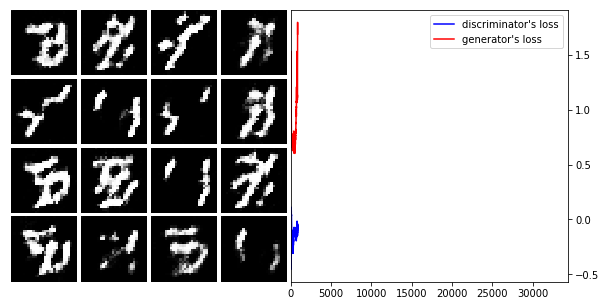

In [12]:
with tf.Session() as sess:

    sess.run(tf.global_variables_initializer())
    
    D_loss_vals = []
    G_loss_vals = []

    iteration = int(mnist.train.images.shape[0] / BATCH_SIZE)
    for e in range(EPOCHS):

        for i in range(iteration):
            x, _ = mnist.train.next_batch(BATCH_SIZE)
            rand = np.random.uniform(0., 1., size=[BATCH_SIZE, 100])
            _, D_loss_curr = sess.run([D_solver, D_loss], {X: x, z: rand})
            rand = np.random.uniform(0., 1., size=[BATCH_SIZE, 100])
            _, G_loss_curr = sess.run([G_solver, G_loss], {z: rand})

            D_loss_vals.append(D_loss_curr)
            G_loss_vals.append(G_loss_curr)

            sys.stdout.write("\r%d / %d: %f, %f" % (i, iteration, D_loss_curr, G_loss_curr))
            sys.stdout.flush()

        data = sess.run(G, {z: rand})
        plot(data, D_loss_vals, G_loss_vals, e, EPOCHS * iteration)